In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(42)
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree
from glob import glob
import PIL
from PIL import Image
import cv2
import os
import shutil
import random
import math
import tensorflow_datasets as tfds

In [ ]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))): 
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [ ]:
def serialize_example(image,label):
    feature = {
        'image':tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'label':_bytes_feature(tf.io.serialize_tensor(label))
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


In [ ]:
!mkdir images

In [ ]:
def tf_writer(op_path,filelist):
    classes=['yawn','no_yawn']
    with tf.io.TFRecordWriter(op_path,options=tf.io.TFRecordOptions(compression_type="GZIP")) as writer:
                random.shuffle(filelist)
                for fn in filelist:
                    label = np.array([0,0],dtype='float64')
                    img = open(fn,'rb').read()
                    lab = fn.split('/')[-2]
                    lab = classes.index(lab)
                    label[lab] = 1.0
                    tf_example = serialize_example(img,label)
                    writer.write(tf_example)

In [ ]:
def create_records(path,op):
    classes=['yawn','no_yawn']
    files_list = glob(path+'/no_yawn/*')
    files_list1 = glob(path+'/yawn/*')
    com_list = files_list + files_list1
    tf_writer(op,com_list)
    

In [ ]:
create_records('/kaggle/input/yawn-eye-dataset-new/dataset_new/train',"train_rec")

In [ ]:
def create_records_test_val(path):
    classes=['yawn','no_yawn']
    files_list = glob(path+'/no_yawn/*')
    files_list1 = glob(path+'/yawn/*')
    com_list = files_list + files_list1
    tf_writer("test_rec",com_list[:len(com_list)//2])
    tf_writer("val_rec",com_list[len(com_list)//2:])
    

In [ ]:
create_records_test_val('/kaggle/input/yawn-eye-dataset-new/dataset_new/test')

In [ ]:
def parse_image(example):
    feature = {'image':tf.io.FixedLenFeature([],tf.string),
              'label':tf.io.FixedLenFeature([],tf.string)}
    features = tf.io.parse_single_example(example,feature)
    image = tf.io.decode_jpeg(features['image'],channels = 3)
    image = tf.image.resize(image,[256,256])
    label = tf.io.parse_tensor(features['label'], out_type=tf.float64)
    label = tf.reshape(label,shape=(2,))
    return image,label


In [ ]:
def read_dataset(filename,batchs):
    data = tf.data.TFRecordDataset(filename,compression_type = "GZIP")
    ds = configure(data)
    return ds


In [ ]:
def configure(data):
    data = data.map(parse_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    data = data.shuffle(500)
    data = data.batch(32,drop_remainder = True)
    data = data.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return data

In [ ]:
def use_records():
    train = read_dataset("./train_rec",32)
    val = read_dataset("./val_rec",32)
    test = read_dataset("./test_rec",32)
    return train,val,test
train_ds,val_ds,test_ds= use_records()    

In [ ]:
train_ds,val_ds

(<PrefetchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float64)>,
 <PrefetchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float64)>)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (32, 256, 256, 3)
Label:  (32, 2)


Label:  [1. 0.]


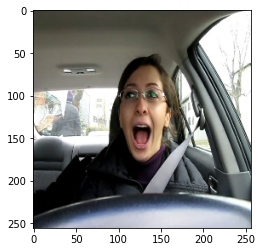

In [ ]:
for image, label in train_ds.take(1):
  print("Label: ", label.numpy()[0])
  plt.imshow(image.numpy()[0].astype("uint8"))

In [ ]:
# Label [0,1] => No Yawn  
# Label [1,0] =>  Yawn - Alert

In [ ]:
cb = [tf.keras.callbacks.ModelCheckpoint("./best_model.h5",monitor='val_accuracy',save_best_only=True,mode='max')]

In [ ]:
pre_trained = tf.keras.applications.vgg16.VGG16(input_tensor = tf.keras.Input(shape = (256,256,3),batch_size = 32),
                                                include_top = False,
                                             
                                               )
pre_trained.trainable = False

In [ ]:
def build():
  model = tf.keras.Sequential([
  tf.keras.layers.Resizing(256,256),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip(mode="horizontal"),
  tf.keras.layers.RandomRotation(0.2, fill_mode='reflect',interpolation='bilinear'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2,activation='softmax')
 ])
  model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])
  return model  

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_12 (Resizing)       (32, 256, 256, 3)         0         
_________________________________________________________________
rescaling_12 (Rescaling)     (32, 256, 256, 3)         0         
_________________________________________________________________
random_flip_12 (RandomFlip)  (32, 256, 256, 3)         0         
_________________________________________________________________
random_rotation_12 (RandomRo (32, 256, 256, 3)         0         
_________________________________________________________________
random_contrast_9 (RandomCon (32, 256, 256, 3)         0         
_________________________________________________________________
random_zoom_9 (RandomZoom)   (32, 256, 256, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (32, 8, 8, 512)          

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
deep_model = model.fit(train_ds,validation_data=val_ds,epochs =30,callbacks=cb)

**After Training and Validating for a long time ,The Best model is saved and uploaded below**

In [ ]:
loaded = tf.keras.models.load_model("/kaggle/input/drowsy-weights/yawn_detection.h5")

In [ ]:
loaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9

In [ ]:
loaded.evaluate(test_ds)

3/3 [==============================] - 0s 30ms/step - loss: 0.1438 - accuracy: 0.9271


[0.14381378889083862, 0.9270833134651184]

In [ ]:
loaded.evaluate(val_ds)

3/3 [==============================] - 0s 29ms/step - loss: 0.0074 - accuracy: 1.0000


[0.007394092623144388, 1.0]

In [ ]:
loaded.evaluate(train_ds)

38/38 [==============================] - 3s 60ms/step - loss: 0.0539 - accuracy: 0.9852


[0.053871531039476395, 0.9851973652839661]

Prediction : Yawn


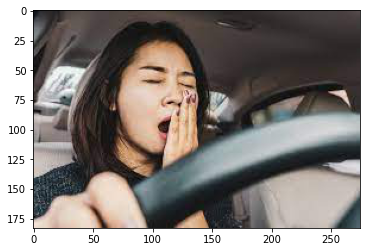

Prediction : Yawn


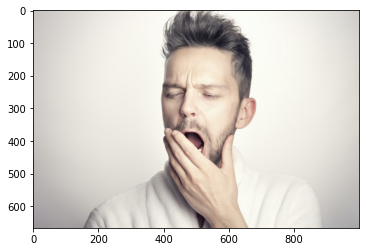

Prediction : Not Yawning


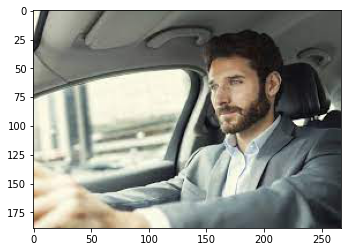

Prediction : Not Yawning


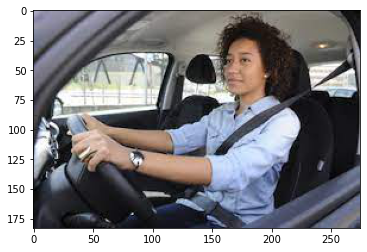

Prediction : Not Yawning


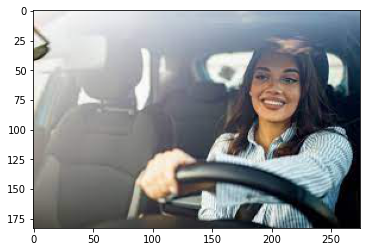

Prediction : Yawn


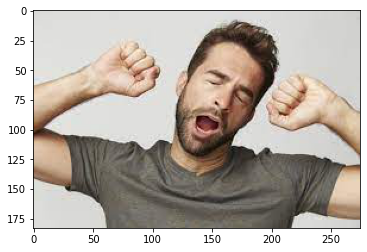

Prediction : Yawn


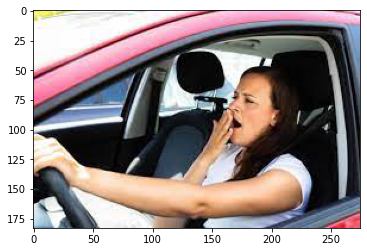

Prediction : Not Yawning


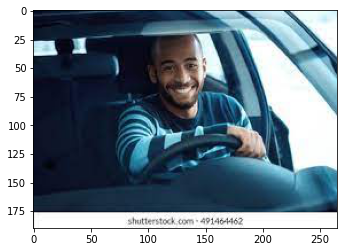

In [ ]:
for i in glob("/kaggle/input/yawn-test-data/imgs/*"):
    im = plt.imread(i)
    plt.imshow(im)
    img = tf.expand_dims(im,axis = 0)
    if np.argmax(np.squeeze(np.round(loaded(img)))) == 0:
        print("Prediction : Yawn")
    else:
        print("Prediction : Not Yawning")
    plt.show()

In [ ]:
model.save("Yawn_Detection.h5")